## Install and Import Dependencies

In [ ]:
# install wandb
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 36.6 MB/s 
     |████████████████████████████████| 182 kB 65.4 MB/s 
     |████████████████████████████████| 168 kB 70.4 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 168 kB 53.1 MB/s 
     |████████████████████████████████| 166 kB 75.2 MB/s 
     |████████████████████████████████| 166 kB 28.6 MB/s 
     |████████████████████████████████| 162 kB 51.4 MB/s 
     |████████████████████████████████| 162 kB 49.5 MB/s 
     |████████████████████████████████| 158 kB 49.8 MB/s 
     |████████████████████████████████| 157 kB 48.3 MB/s 
     |████████████████████████████████| 157 kB 9.0 MB/s 
     |████████████████████████████████| 157 kB 55.4 MB/s 
     |████████████████████████████████| 157 kB 11.6 MB/s 
     |████████████████████████████████| 157 kB 53.2 MB/s 
     |████████████████████████████████| 157 kB 41.2 MB/s 
     |████████████████████████████████| 157 kB 43.5 MB/s 
     |███████████

In [ ]:
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 28.2 MB/s 
     |████████████████████████████████| 46 kB 5.2 MB/s 
     |████████████████████████████████| 66 kB 4.1 MB/s 


In [ ]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
import tensorflow as tf
import wandb
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from codecarbon import EmissionsTracker

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

## Fetch and Data Segregation

In [ ]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "face_mask_detection",
  "artifact_name": "face_mask_raw_data:latest",
}

In [ ]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="marianabritoazevedo",project=args["project_name"], job_type="preprocessing")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

wandb: Currently logged in as: marianabritoazevedo. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact face_mask_raw_data:latest, 328.92MB. 11792 files... 
wandb:   11792 of 11792 files downloaded.  
Done. 0:3:56.4
22-11-2022 21:52:47 Path: ./artifacts/face_mask_raw_data:v0


In [ ]:
run.finish()

In [ ]:
data_dir

'./artifacts/face_mask_raw_data:v0'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

raw_wb = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     image_size=IMG_SIZE,
                                                     label_mode='categorical')

Found 11792 files belonging to 2 classes.


80% for train and 20% for validation and test

In [ ]:
all_batches = tf.data.experimental.cardinality(raw_wb)
valtest_dataset = raw_wb.take(all_batches // 5)
train_dataset = raw_wb.skip(all_batches // 5)

valtest_batches = tf.data.experimental.cardinality(valtest_dataset)
test_dataset = valtest_dataset.take(valtest_batches // 5)
validation_dataset = valtest_dataset.skip(valtest_batches // 5)

In [ ]:
print('Number of raw batches: %d' % tf.data.experimental.cardinality(raw_wb))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of raw batches: 369
Number of train batches: 296
Number of validation batches: 59
Number of test batches: 14


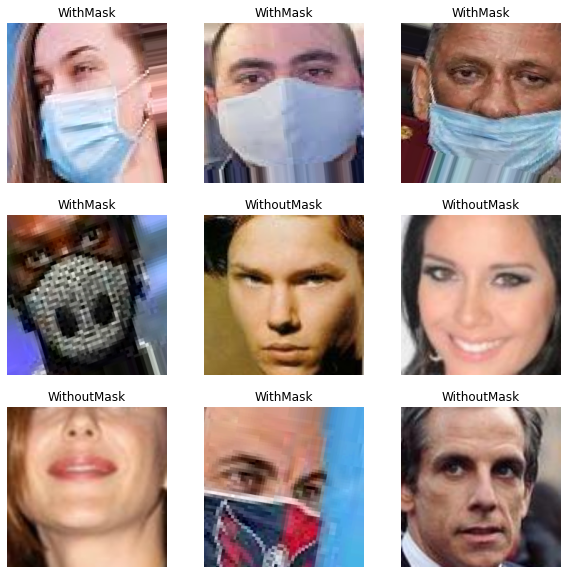

In [ ]:
class_names = raw_wb.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")

## Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting. You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

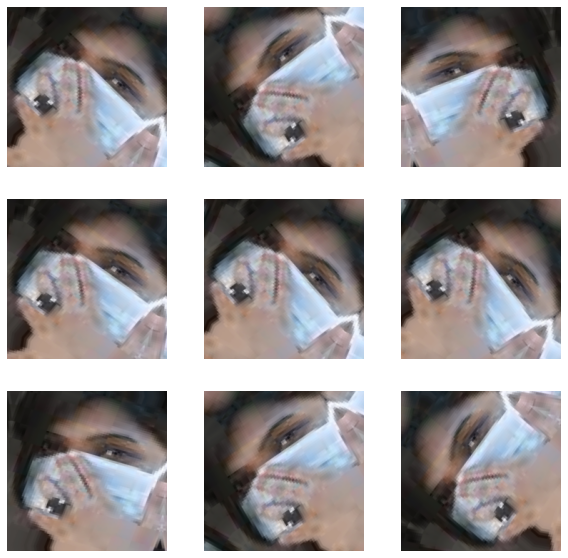

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Create the base model from the pre-trained convnets


You will create the base model from the [VGG16 model](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16). This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of VGG16 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a VGG16 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.




In [ ]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

This feature extractor converts each 224x224x3 image into a 7x7x512 block of features. Let's see what it does to an example batch of images:




In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


## Feature extraction

In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. VGG16 has many layers, so setting the entire model's trainable flag to False will freeze all of them. This is crucial only in case we are using [tf.keras.layers.BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) layers in the model.

> Many models contain [tf.keras.layers.BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this notebook.

When you set ``layer.trainable = False``, the **BatchNormalization** layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains **BatchNormalization** layers in order to do fine-tuning, you should keep the **BatchNormalization** layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [ ]:
model.trainable = False

#### Step 0: Start running project at Wandb

In [ ]:
args = {
  "project_name": "face_mask_detection"
}

In [ ]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="marianabritoazevedo",
                 project=args["project_name"], 
                 job_type="Train")

#### Step 1: Add a classification head

To generate predictions from the block of features, average over the spatial 7x7 spatial locations, using a [tf.keras.layers.GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer to convert the features to a single 512-element vector per image.




In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


Apply a [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer to convert these features into a single prediction per image.

In [ ]:
prediction_layer = tf.keras.layers.Dense(2,"softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


Build a model by chaining together the data augmentation, [tf.keras.applications.vgg16.preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input), model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use ``training=False`` is only redundant because our models not contains a BatchNormalization layer. However, use it here is important for the sake of understanding. 

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

#### Step 2: Compile the model

Compile the model before training it.

In [ ]:
# initialize the optimizer and model
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

The 14.714.688 million parameters in VGG16 are frozen, but there are 1,539 thousand trainable parameters in the Dense layer. These are divided between two [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable) objects, the weights and biases.




#### Step 3: Train 

In [ ]:
tracker = EmissionsTracker(log_level="critical")
tracker.start()

history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=10,
                    verbose=1)

emissions = tracker.stop()

Epoch 1/10
296/296 [==============================] - 70s 221ms/step - loss: 1.2102 - accuracy: 0.6850 - val_loss: 0.2872 - val_accuracy: 0.8893
Epoch 2/10
296/296 [==============================] - 69s 224ms/step - loss: 0.3229 - accuracy: 0.8987 - val_loss: 0.1112 - val_accuracy: 0.9688
Epoch 3/10
296/296 [==============================] - 72s 232ms/step - loss: 0.1808 - accuracy: 0.9411 - val_loss: 0.0633 - val_accuracy: 0.9772
Epoch 4/10
296/296 [==============================] - 73s 236ms/step - loss: 0.1259 - accuracy: 0.9575 - val_loss: 0.0421 - val_accuracy: 0.9836
Epoch 5/10
296/296 [==============================] - 72s 233ms/step - loss: 0.1005 - accuracy: 0.9674 - val_loss: 0.0231 - val_accuracy: 0.9931
Epoch 6/10
296/296 [==============================] - 73s 232ms/step - loss: 0.0864 - accuracy: 0.9723 - val_loss: 0.0245 - val_accuracy: 0.9931
Epoch 7/10
296/296 [==============================] - 73s 235ms/step - loss: 0.0667 - accuracy: 0.9779 - val_loss: 0.0216 - val_ac

#### Step 4: Metrics for training

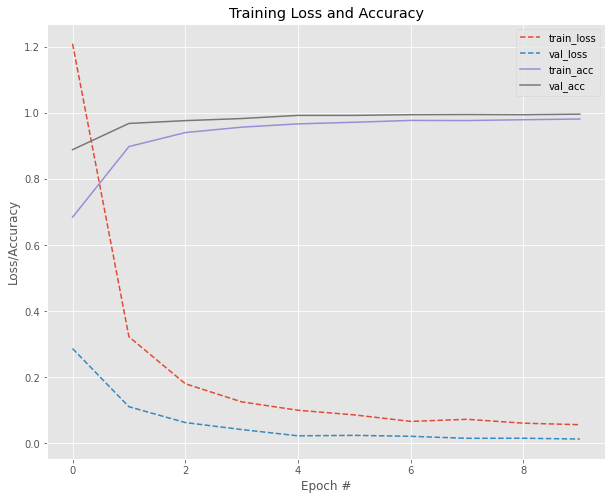

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 10), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 10), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [ ]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.023632764406687608 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0010288779672412408 kWh
[INFO] Energy consumed for all GPU: 0.013400052624818746 kWh
[INFO] Energy consumed for all CPU: 0.009203833814627594 kWh
[INFO] CO2 emission 0.014911876445906901(in Kg)


#### Step 5: Test and metrics

In [ ]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names, digits=4) 
                            )

[INFO] evaluating network...
14/14 [==============================] - 2s 161ms/step
              precision    recall  f1-score   support

    WithMask     0.9908    0.9863    0.9886       219
 WithoutMask     0.9870    0.9913    0.9891       229

    accuracy                         0.9888       448
   macro avg     0.9889    0.9888    0.9888       448
weighted avg     0.9888    0.9888    0.9888       448



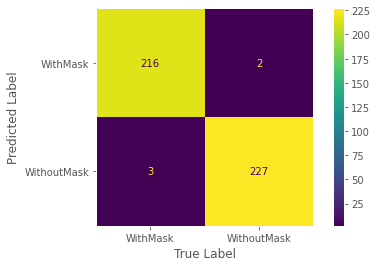

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

#### Step 6: Evaluations metrics for Wandb

In [ ]:
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
    }
)

22-11-2022 22:09:08 Uploading figures


In [ ]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(labels.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(labels.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(labels.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(labels.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

22-11-2022 22:10:59 Validation Evaluation metrics
22-11-2022 22:10:59 Validation Accuracy: 0.9888392857142857
22-11-2022 22:10:59 Validation Precision: 0.9888479222462819
22-11-2022 22:10:59 Validation Recall: 0.9888392857142857
22-11-2022 22:10:59 Validation F1: 0.9888386736591406


In [ ]:
run.finish()

Acc,0.98884
CO2_Emissions,0.01491
Count_Params,14715714
Energy_CPU,0.0092
Energy_Consumed,0.02363
Energy_GPU,0.0134
Energy_RAM,0.00103
F1,0.98884
Precision,0.98885
Recall,0.98884


## Fine-tuning

In the previous section we learned how to treat a pre-trained **Convolutional Neural Network** as **feature extractor**. 

> Using this feature extractor, we forward propagated our dataset of images through the network, extracted the activations at a given layer, and saved the values to disk. A shallow machine
learning classifier was then trained on top of the CNN features.

This CNN feature extractor approach, called **transfer learning**, obtained remarkable accuracy, far higher than any of our previous experiments on the Animals dataset.

But there is another type of transfer learning, one that can actually outperform the feature extraction method if you have sufficient data. This method is called **fine-tuning** and **requires us to perform “network surgery”**. 

1. First, we take a **scalpel and cut off the final set of fully-connected layers** (i.e., the “head” of the network) from a pre-trained /Convolutional Neural Network, such as
VGG, ResNet, Inception, so on. 
2. We then **replace the head** with a new set of fully-connected layers with random initializations. From there all layers below the head are frozen so their weights cannot be
updated (i.e., the backward pass in backpropagation does not reach them)
3.  We then train the network **using a very small learning rate** so the new set of FC layers can start to learn patterns from the previously learned CONV layers earlier in the network. 
4. Optionally, we may unfreeze the rest of the network and continue training. Applying fine-tuning allows us to apply pre-trained networks to recognize classes that they were not originally trained on; furthermore, **this method can lead to higher accuracy than feature extraction**.

#### About fine-tuning

**Fine-tuning is a type of transfer learning**. We apply fine-tuning to deep learning models that have already been trained on a given dataset. Typically, these networks are state-of-the-art architectures
such as VGG, ResNet, and Inception that have been trained on the ImageNet dataset.

As we found out in previous section on feature extraction, these networks contain rich, discriminative filters that can be used on datasets and class labels outside the ones they have already been trained on. However, instead of simply applying feature extraction, we are going to perform network surgery and modify the actual architecture so we can re-train parts of the network.


If this sounds like something out of a bad horror movie; don’t worry, there won’t be any blood and gore – but we will have some fun and learn a lot with our experiments. To understand how finetuning
works, consider Figure below (left) where we have the layers of the VGG16 network. As we know, the final set of layers (i.e., the “head”) are our fully-connected layers along with our softmax classifier. When performing fine-tuning, we actually remove the head from the network, just as in feature extraction (middle). However, unlike feature extraction, when we perform fine-tuning we actually **build a new fully-connected head and place it on top of the original architecture
(right)**.


<center><img width="600" src="https://drive.google.com/uc?export=view&id=1qTj4KeosAyDUcffqTQ_BepiINEUXs-cE"></center><center><b>Left</b>:  The original VGG16 network architecture. <b>Middle</b>: Removing the FC layers from VGG16 and treating the final POOL layer as a feature extractor. <b>Right</b>: Removing the original FC layers and replacing them with a brand new FC head. These new FC layers can then be fine-tuned to the specific dataset (the old FC layers are no longer used).</center>


In most cases your new FC head will have fewer parameters than the original one; however, that really depends on your particular dataset. The new FC head is randomly initialized (just like any other layer in a new network) and connected to the body of the original network, and we are ready to train.

However, there is a problem – our CONV layers have already learned rich, discriminating filters while our FC layers are brand new and totally random. If we allow the gradient to backpropagate from these random values all the way through the body of our network, we risk destroying these powerful features. To circumvent this, we instead let our FC head “warm up” by (ironically) “freezing” all layers in the body of the network as
in Figure below (left).



<center><img width="600" src="https://drive.google.com/uc?export=view&id=11Zh6mGG3qMISsnCg6JLgL-sH7TnxpUSC"></center><center><b>Left</b>: When we start the fine-tuning process we freeze all CONV layers in the network and only allow the gradient to backpropagate through the FC layers. Doing this allows our network to “warm up”. <b>Right</b>: After the FC layers have had a chance to warm up we may choose to unfreeze all layers in the network and allow each of them to be fine-tuned as well.</center>


Training data is forward propagated through the network as we normally would; however, the backpropagation is stopped after the FC layers, which allows these layers to start to learn patterns from the highly discriminative CONV layers. In some cases, we may never unfreeze the body of the network as our new FC head may obtain sufficient accuracy. 

However, for some datasets it is often advantageous to allow the original CONV layers to be modified during the fine-tuning process as
well (Figure above, right).

After the FC head has started to learn patterns in our dataset, pause training, unfreeze the body, and then continue the training, but with a very **small learning rate** – we do not want to deviate our
CONV filters dramatically. 

Training is then allowed to continue until sufficient accuracy is obtained. Fine-tuning is a super powerful method to obtain image classifiers from pre-trained CNNs on custom datasets, even more powerful than feature extraction in most cases. **The downside is that
fine-tuning can require a bit more work and your choice in FC head parameters does play a big part
in network accuracy** – you can’t rely strictly on regularization techniques here as your network has already been pre-trained and you can’t deviate from the regularization already being performed by
the network.

Secondly, for small datasets, it can be challenging to get your network to start “learning” from a “cold” FC start, which is why we freeze the body of the network first. Even still, getting past the warm-up stage can be a bit of a challenge and might require you to use optimizers other than SGD. **While fine-tuning does require a bit more effort, if it is done correctly, you’ll nearly always enjoy higher accuracy**.

#### Step 0: Start running project at Wandb

In [ ]:
args = {
  "project_name": "face_mask_detection"
}

In [ ]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="marianabritoazevedo",
                 project=args["project_name"], 
                 job_type="Train")

#### Step 1: Organizing Indexes and Layers

Prior to performing **network surgery**, we need to know the **layer name and index** of every layer in a given deep learning model. We need this information as we’ll be required to **“freeze”** and **“unfreeze”** certain layers in a pre-trained CNN.

Without knowing the layer names and indexes ahead of time, we would be “cutting blindly”, an out-of-control surgeon with no game plan. **If we instead take a few minutes to examine the network architecture and implementation, we can better prepare for our surgery.**

In [ ]:
# import the necessary packages
from tensorflow.keras.applications import VGG16

# whether or not to include top of CNN
include_top = 0

# load the VGG16 network
print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top= include_top > 0)
print("[INFO] showing layers...")

# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] loading network...
[INFO] showing layers...
[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D


Before we can replace the head of a pre-trained CNN, we need something to replace it with – therefore, we need to define our own fully-connected head of the network.

In [ ]:
# import the necessary packages
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# a fully connect network
class FCHeadNet:
	@staticmethod
	def build(baseModel, classes, neurons):
		# initialize the head model that will be placed on top of
		# the base, then add a FC layer
		headModel = baseModel.output
		headModel = Flatten(name="flatten")(headModel)
		headModel = Dense(neurons, activation="relu")(headModel)
		headModel = Dropout(0.5)(headModel)

		# add a softmax layer
		headModel = Dense(classes, activation="softmax")(headModel)

		# return the model
		return headModel

Again, this fully-connected head is very simplistic compared to the original head from VGG16 which consists of two sets of 4,096 FC layers. However, for most fine-tuning problems you are not seeking to replicate the original head of the network, but rather simplify it so it is easier to fine-tune– the fewer parameters in the head, the more likely we’ll be to correctly tune the network to a new
classification task.


In some cases you’ll want to allow the entire body to be trainable; however, **for deeper architectures with many parameters such as VGG, I suggest only unfreezing the top CONV layers and then continuing training**. If classification accuracy continues to improve (without overfitting), you may want to consider unfreezing more layers in the body.

#### Step 2: First Stage of training

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD

In [ ]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
outputs = base_model(x, training=False)
base_model = tf.keras.Model(inputs, outputs)

In [ ]:
base_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
Total params: 14,714,688
Trainable params: 14,714,688
Non-t

In [ ]:
# initialize the new head of the network, a set of FC layers
# followed by a softmax classifier
headModel = FCHeadNet.build(base_model, len(class_names), 256)

In [ ]:
# place the head FC model on top of the base model -- this will
# become the actual model we will train
model = Model(inputs=base_model.input, outputs=headModel)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [ ]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [ ]:
# loop over all layers in the base model and freeze them so they
# will *not* be updated during the training process
for layer in model.layers[4].layers:
	layer.trainable = False

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [ ]:
# RMSprop is frequently used in situations where we need to quickly obtain
# reasonable performance (as is the case when we are trying to “warm up” a set of FC layers).
opt = RMSprop(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [ ]:
# train the head of the network for a few epochs (all other
# layers are frozen) -- this will allow the new FC layers to
# start to become initialized with actual "learned" values
# versus pure random
tracker = EmissionsTracker(log_level="critical")
tracker.start()

print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=3,
                    verbose=1)

emissions = tracker.stop()

[INFO] training head...
Epoch 1/3
296/296 [==============================] - 69s 220ms/step - loss: 0.2159 - accuracy: 0.9820 - val_loss: 0.0082 - val_accuracy: 0.9984
Epoch 2/3
296/296 [==============================] - 73s 233ms/step - loss: 0.0745 - accuracy: 0.9942 - val_loss: 0.0206 - val_accuracy: 0.9979
Epoch 3/3
296/296 [==============================] - 73s 238ms/step - loss: 0.0399 - accuracy: 0.9958 - val_loss: 0.0228 - val_accuracy: 0.9989


#### Step 3: Second stage of training

In [ ]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [ ]:
# loop over the layers in the base model network and display them to the
# console
for (i, layer) in enumerate(model.layers[4].layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D


In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [ ]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in model.layers[4].layers[15:]:
	layer.trainable = True

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [ ]:
# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

[INFO] re-compiling model...


In [ ]:
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers

tracker2 = EmissionsTracker(log_level="critical")
tracker2.start()

print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=10,
                    verbose=1)

emissions2 = tracker2.stop()

[INFO] training head...
Epoch 1/10
296/296 [==============================] - 82s 258ms/step - loss: 0.0341 - accuracy: 0.9962 - val_loss: 0.0260 - val_accuracy: 0.9984
Epoch 2/10
296/296 [==============================] - 80s 259ms/step - loss: 0.0423 - accuracy: 0.9956 - val_loss: 0.0206 - val_accuracy: 0.9979
Epoch 3/10
296/296 [==============================] - 80s 261ms/step - loss: 0.0219 - accuracy: 0.9974 - val_loss: 0.0161 - val_accuracy: 0.9989
Epoch 4/10
296/296 [==============================] - 80s 261ms/step - loss: 0.0267 - accuracy: 0.9968 - val_loss: 0.0248 - val_accuracy: 0.9979
Epoch 5/10
296/296 [==============================] - 80s 259ms/step - loss: 0.0205 - accuracy: 0.9980 - val_loss: 0.0131 - val_accuracy: 0.9989
Epoch 6/10
296/296 [==============================] - 80s 259ms/step - loss: 0.0215 - accuracy: 0.9977 - val_loss: 0.0177 - val_accuracy: 0.9979
Epoch 7/10
296/296 [==============================] - 80s 259ms/step - loss: 0.0292 - accuracy: 0.9967 - v

Additional accuracy can be obtained by performing more aggressive data augmentation and continually unfreezing more and more CONV blocks in VGG16. While fine-tuning is certainly more work than feature extraction, it also enables us to tune and modify the weights in our CNN to a particular dataset – something that feature extraction does not allow. Thus, when given enough training data, consider applying fine-tuning as you’ll likely obtain higher classification accuracy
than simple feature extraction alone.

#### Step 4: Metrics for training

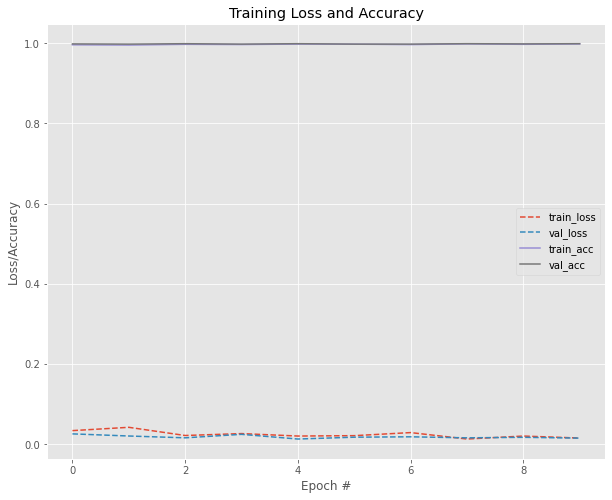

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 10), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 10), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [ ]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed+tracker2.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy+tracker2.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy+tracker2.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy+tracker2.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions+tracker2.final_emissions_data.emissions))

[INFO] 0.03197163844556206 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0013576312782281465 kWh
[INFO] Energy consumed for all GPU: 0.01846870707122604 kWh
[INFO] Energy consumed for all CPU: 0.012145300096107856 kWh
[INFO] CO2 emission 0.020173565566392885(in Kg)


#### Step 5: Test and metrics

In [ ]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names,
                            digits=4))

[INFO] evaluating network...
14/14 [==============================] - 2s 163ms/step
              precision    recall  f1-score   support

    WithMask     0.9907    1.0000    0.9953       214
 WithoutMask     1.0000    0.9915    0.9957       234

    accuracy                         0.9955       448
   macro avg     0.9954    0.9957    0.9955       448
weighted avg     0.9956    0.9955    0.9955       448



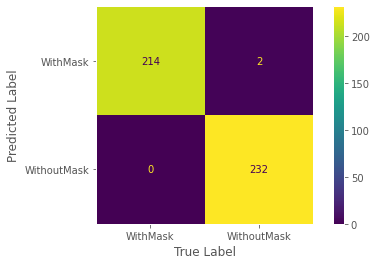

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

#### Step 6: Evaluations metrics for Wandb

In [ ]:
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
    }
)

22-11-2022 22:34:31 Uploading figures


In [ ]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(labels.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(labels.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(labels.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(labels.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

22-11-2022 22:34:49 Validation Evaluation metrics
22-11-2022 22:34:49 Validation Accuracy: 0.9955357142857143
22-11-2022 22:34:49 Validation Precision: 0.9955770502645501
22-11-2022 22:34:49 Validation Recall: 0.9955357142857143
22-11-2022 22:34:49 Validation F1: 0.9955365163332525


In [ ]:
run.finish()

Acc,0.99554
CO2_Emissions,0.00439
Count_Params,21137986
Energy_CPU,0.00265
Energy_Consumed,0.00696
Energy_GPU,0.00401
Energy_RAM,0.0003
F1,0.99554
Precision,0.99558
Recall,0.99554
